# SENTIMENT ANALYSIS AND OPINION MINING PROJECT
## PUBLIC OPINION ON NEWS

https://island.ricerca.di.unimi.it/~alfio/shared/textsent/2020-21/projects.html

The New York Times Comments dataset (https://www.kaggle.com/aashita/nyt-comments?select=CommentsApril2017.csv) contains articles published on the New York Times and the comments they received from readers. <br>
The task of the project is to analyze, using the variables *editorsSelection*, *recommendations*, and *replyCount* as targets, the rate of success of a comment. This rate of success should be intepreted as a measure of how much controversial was the commented article. On this base, the project aims at studing which topics (indicated by the features sectionName and/or newDesk) were mostly controversial. Optionally, the project could also determine if a comment opinion is against or if favor of the article.

# 2. CLASSIFICATION OF CONTROVERSIAL COMMENTS WITH A MULTIMODAL NEURAL NETWORK

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

import os
import pickle
from tqdm.auto import tqdm
import json
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import gensim
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm
import random
import types

import optuna
import torch.nn as nn
import torch.optim as optim
import pickle
import re
import sqlite3
from sqlalchemy import create_engine


/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## DATA LOADER

In [3]:
# if the gpu is available the model is moved on the gpu memory
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [50]:
class Data_Load():
    
  """
    Load the New York Times Dataset preprocessed data to be used.
        
    Parameters:
    ------------------
    data_path (str): path of the dataset.
        
    Raises:
    ------------------
    ValueError,
        If network_type parameter value is wrong.
        
    Returns:
    ------------------
    Dataframe of variables, Dataframe of labels.  
  """
    
  def  __init__(self, 
               data_path):
    self.data_path = data_path
    self.X = []
    self.y =  []
        

  def load(self):
    
    # load the labels
    self.y =  pd.read_csv(
      os.path.join('data', self.data_path),
      usecols = ['editorsSelection_TARGET','recommendations_TARGET','replyCount_TARGET']
      ) 
    # fix columns type
    self.y  = self.y .astype({
        'editorsSelection_TARGET': 'int',
        'recommendations_TARGET': 'int',
        'replyCount_TARGET': 'int'})
 
    
    # load the data features based on the chosen neural network
    self.X  = pd.read_csv(
        os.path.join('data',self.data_path),
        usecols = ['approveDate','commentType','createDate','depth','picURL','sharing','timespeople',
                  'trusted','updateDate','userTitle','sectionName_x','newDesk_x','articleWordCount_x','printPage_x',
                  'typeOfMaterial_x','documentType','pubDate','source','keywords','commentBody']
        ) 
    # fix columns type
    self.X  = self.X .astype({
        'approveDate': 'float64',
        'createDate': 'float64',
        'depth': 'object',
        'picURL': 'object',
        'sharing': 'object',
        'timespeople': 'object',
        'trusted':'object',
        'updateDate': 'float64',
        'articleWordCount_x' : 'float64',
        'printPage_x' : 'object'
                    })
    
    return self.X, self.y

In [107]:
class Data_Preprocess():
  """Preprocess the New York Times Dataset data depending on the data type and the specific network used among
        feed forward, convolutional and doc2vec + convolutional neural network.
        Variables used for feed forward NN are scaled with a robust scaler (numeric) or one-hot-encoded (factors).
        The variable 'keywords' is vectorised by using TF-IDF. The variable 'commentBody' is embedded by using
        doc2vec representation.
        
    Parameters:
    ------------------
    X (pd.DataFrame): dataframe of variables.
    y (pd.DataFrame): dataframe of labels.
        
    Raises:
    ------------------
    ValueError,
        If 'network_type' parameter value is wrong.
    ValueError,
        If 'usage' parameter value is wrong.
        
    Attributes:
    ------------------
    scaler_onehot_dict (dict): it stores for each column a fitted RobustScaler() object for numeric
        variables and a fitted OneHotEncoder() object for categorical variables
    vectorizer: it stores the fitted TfidfVectorizer() object for the variable 'keywords'
    doc2vec_model: it stores the learned embedded representation of the variable 'commentBody'
        by using the doc2vec model. The window for the context is 3. The resulting vector 
        has dimensionality 300.
    
    Returns:
    ------------------
    Tensor of training data, Tensor of training labels, Tensor of test data, Tensor of test labels.
  """
    
  def __init__(self, 
               X,
               y):
  
    self.X1 = X[['approveDate','commentType','createDate','depth','picURL','sharing','timespeople',
                      'trusted','updateDate','userTitle','sectionName_x','newDesk_x','articleWordCount_x','printPage_x',
                      'typeOfMaterial_x','documentType','pubDate','source']]
    self.X2 = X['keywords']
    self.X3 = X['commentBody']
    self.y = y

    # instantiate the attributes for storing the fitted transformation methods
    self.scaler_onehot_dict = {}
    self.vectorizer = []
    self.doc2vec_model = []
      
    self.X_train = []
    self.y_train = []
    self.X_val = []
    self.y_val = []
    self.X_test = []
    self.y_test = []


  def data_process_flat_features(self):
    """Fit a robust scaler for numeric features and one-hot encoding for factors,
    then store it into a dictionary for each column. 
    """
    
    for col in sorted(self.X1.columns):
        # fit robust scaler method on each numeric column and store it into a vocabulary
        if self.X1[col].dtype == object:
            self.scaler_onehot_dict[col] = OneHotEncoder().fit(self.X1[col].values.astype('U').reshape(-1, 1))
        # fit one-hot encoder method on each categorical column and store it into a vocabulary
        elif self.X1[col].dtype == np.float64:
            self.scaler_onehot_dict[col] = RobustScaler().fit(self.X1[col].values.astype('U').reshape(-1,1))
    

  def data_process_tfidf_doc_embedding(self):
    """Fit TF-IDF vectorization method.
    """
    
    # fit TF-IDF vectoriser and store it
    self.vectorizer = TfidfVectorizer() 
    self.vectorizer.fit(self.X2.values.astype('U'))

    
  def tag_docs(self):
    """Returns a list of TaggedDocuement containing the words and a unique tag for the document
    to be used as input for the doc2vec model.
    """
    for i, line in enumerate(self.X3):
      tokens = gensim.utils.simple_preprocess(str(line))
      yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

  def data_process_doc2vec_embedding(self):
    """Learns an embedded representation by using a doc2vec model. The window for the context is 3. 
    The resulting vector has dimensionality 300. Data are not directly transformed to save memory.
    The class attribute 'doc2vec_model' stores the resulting learned model.
    """
    
    X = list(self.tag_docs())
    
    if os.path.exists("misc/doc2vec.pickle"):
      with open("misc/doc2vec.pickle", "rb") as fin:
        model = pickle.load(fin)
    
    else:        
      # build doc2vec representation of documents with dimensionality 300 and window=3
      model = gensim.models.doc2vec.Doc2Vec(vector_size=300, min_count=1, epochs=5, dbow_words=1, window=3) 
      # train model by passing the tagged document and words
      model.build_vocab(X)
      model.train(X, total_examples=model.corpus_count, epochs=model.epochs)
    
      with open("misc/doc2vec.pickle", "wb") as fout:
        pickle.dump(model, fout)

    self.doc2vec_model = model
        

  def split_data(self, X, usage, test_size, validation_size):
    """It splits the dataset into training and test set, if usage is 'model_testing'. Else if usage
     is 'hyper_tuning', it splits the trianing set again into a training and validation set, discarding
     the test set.
    """
    
    assert (X.shape[0] == self.y.shape[0])
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, self.y,
                                                        test_size=test_size, 
                                                        shuffle=True) 


    if usage == 'hyper_tuning':
      assert (self.X_train.shape[0] == self.y_train.shape[0])

      self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X_train, self.y_train,
                                                        test_size=validation_size, 
                                                        shuffle=True) 
        
    # reset indexes of dataframe
    self.X_train = self.X_train.reset_index(drop=True)
    self.X_test = self.X_test.reset_index(drop=True)
    self.y_train = self.y_train.reset_index(drop=True)
    self.y_test = self.y_test.reset_index(drop=True)
    
    
  def fit(self):
    """Apply trasformations depending on the data
    """

    # fit transformation methods if not aready fitted
    if not self.scaler_onehot_dict:
        self.data_process_flat_features()
    if not self.vectorizer:
        self.data_process_tfidf_doc_embedding()
    if not self.doc2vec_model:
        self.data_process_doc2vec_embedding()
            
    
  def get_data(self, network_type, usage, test_size=0.25, validation_size=0.15):
    """Split the dataset and returns data depending on the neural network used.
    
    Parameters: 
    ----------------
    network_type (str): type of neural network to be used. Possible values are:
        'FFNN' (feed forward), CNN (convolutional), D2V_CNN (doc2vec + convolutional)
        Default: None
    usage (str): either hyperparameters tuning or model testing. In the first case it creates a training and 
        validation set, leaving out the test set. In the seconc case it creates a training and test set.
        Possible values are: 'hyper_tuning' or 'model_testing'
        Default: None
    test_size (float): size of the test set.
        Default: 0.25
    validation_size (float): size of the validation set.
        Default: 0.15
        
        
    Returns: 
    ----------------
        Tensor of training data, Tensor of training labels, Tensor of test data, Tensor of test labels. 
    """
    
    if network_type not in ['FFNN','CNN','D2V_CNN']:
            raise ValueError(
            "Argument 'network_type' has an incorrect value: use 'FFNN', 'CNN', 'D2V_CNN'")

    
    if usage not in ['hyper_tuning', 'model_testing']:
            raise ValueError(
            "Argument 'usage' has an incorrect value: use 'hyper_tuning', 'model_testing'")
            
    # split into training and test set
    if network_type == 'FFNN':
        self.split_data(self.X1, usage, test_size, validation_size)
    if network_type == 'CNN':
        self.split_data(self.X2, usage, test_size, validation_size)
    if network_type == 'D2V_CNN':
        self.split_data(self.X3, usage, test_size, validation_size)

        
    return self.X_train, self.y_train, self.X_test, self.y_test


In [126]:
class Dataset_Wrap(Dataset):
    
  """Creates a Dataset object for building a DataLoader object.
        
    Parameters:
    ------------------
    X (torch.Tensor): tensor of variables.
    y (torch.Tensor): tensor of labels.
    network_type (str): type of neural network to be used. Possible values are:
        'FFNN' (feed forward), CNN (convolutional), D2V_CNN (word embeddings + convolutional)
    scaler_onehot_dict: fitted robust scaler for numeric variables and fitted one-hot encoder
        for categorical values.
        Default: None
    vectorizer: fitted TF-IDF model
        Default: None
    doc2vec_model: learned representation of the variable 'commentBody' through doc2vec model
        Default: None
    
    Returns:
    ----------------
        i-th data and labels. Move the tensors to GPU if available
  """
    
  def __init__(self, X, y, network_type, scaler_onehot_dict = None, vectorizer = None, doc2vec_model=None):
    self.X = X
    self.y = y
    self.network_type = network_type
    self.vectorizer = vectorizer
    self.scaler_onehot_dict =  scaler_onehot_dict
    self.doc2vec_model = doc2vec_model

  def __len__(self):
    """Returns the number of observations."""
    return (self.X.shape[0])  

  def __getitem__(self, i):
    """Returns:
    ----------------
        i-th data and labels depending on the model used. 
        Move the tensors to GPU if available, otherwise use CPU."""
    
    if self.network_type == 'FFNN':

        data = torch.empty(0)
        
        for col in sorted(self.X.columns):
            x = self.scaler_onehot_dict[col].transform(np.array(self.X[col][i]).astype('U').reshape(-1, 1))
            data = hstack((data,x))        

        data = torch.tensor(data.todense()).reshape(-1)
        
        
    if self.network_type == 'CNN':
        
        data = self.vectorizer.transform([str(self.X[i])])
        data = torch.tensor( data.todense().reshape(1,-1) )
        
    if self.network_type == 'D2V_CNN':
        
        data = torch.tensor(self.doc2vec_model.infer_vector( str(self.X[i] ).split()))
        data = torch.reshape(data, (1, len(data)))

    # return labels
    labels = torch.tensor(self.y.values[i].astype(int))
    y_1, y_2, y_3 = labels
          
    return (data.to(device), y_1.to(device), y_2.to(device), y_3.to(device))


Remove userLocation and inline due to RAM problems in processing them since they have too many features

In [109]:
# load data
X, y = Data_Load(data_path='dataset_cleansed_version.csv').load()
  
# preprocess data
data_processed = Data_Preprocess(X=X,y=y) 
data_processed.fit()

In [54]:
data_processed.doc2vec_model

In [55]:
data_processed.scaler_onehot_dict

{'approveDate': RobustScaler(),
 'articleWordCount_x': RobustScaler(),
 'commentType': OneHotEncoder(),
 'createDate': RobustScaler(),
 'depth': OneHotEncoder(),
 'documentType': OneHotEncoder(),
 'newDesk_x': OneHotEncoder(),
 'picURL': OneHotEncoder(),
 'printPage_x': OneHotEncoder(),
 'pubDate': RobustScaler(),
 'sectionName_x': OneHotEncoder(),
 'sharing': OneHotEncoder(),
 'source': OneHotEncoder(),
 'timespeople': OneHotEncoder(),
 'trusted': OneHotEncoder(),
 'typeOfMaterial_x': OneHotEncoder(),
 'updateDate': RobustScaler(),
 'userTitle': OneHotEncoder()}

In [56]:
data_processed.vectorizer

TfidfVectorizer()

In [112]:
def build_DataLoader(
    data_processed, 
    network_type, 
    usage, 
    test_size=0.25, 
    validation_size=0.15,
    batch_size = 100):
    
        """Build a function that process data and return a DataLoader object that can be directly passed as 
        input to the neural network.

        Parameters:
        ------------------
        processed_data: object of class Data_Preprocess() where the method fit has been
            already called.
        network_type (str): type of neural network to be used. Possible values are:
            'FFNN' (feed forward), CNN (convolutional), EMB_CNN (word embeddings + convolutional)
            Default: None
        usage (str): either hyperparameters tuning or model testing. In the first case it creates a training and 
            validation set, leaving out the test set. In the seconc case it creates a training and test set.
            Possible values are: 'hyper_tuning' or 'model_testing'
            Default: None
        test_size (float): size of the test set.
            Default: 0.25
        validation_size (float): size of the validation set.
            Default: 0.15
        batch_size (int): size of the training batches. The size of the testing batches is doubled.
            Default: 100

        Returns:
        ------------------
        Training DataLoader object, Testing DataLoader object
        """

        X_train, y_train, X_test, y_test = data_processed.get_data(network_type=network_type,
                                                               usage=usage, 
                                                               test_size=test_size,
                                                               validation_size=validation_size)


        # create data wrapper
        train_wrap = Dataset_Wrap(X_train, y_train, network_type=network_type, 
                                  scaler_onehot_dict=data_processed.scaler_onehot_dict,
                                  vectorizer=data_processed.vectorizer,
                                  doc2vec_model=data_processed.doc2vec_model)

        test_wrap = Dataset_Wrap(X_test, y_test, network_type=network_type, 
                                 scaler_onehot_dict=data_processed.scaler_onehot_dict,
                                 vectorizer=data_processed.vectorizer,
                                 doc2vec_model=data_processed.doc2vec_model)

        # create DataLoader object
        loader_train = DataLoader(dataset = train_wrap, batch_size = batch_size, shuffle=True)             
        loader_test = DataLoader(dataset = test_wrap, batch_size = batch_size*2, shuffle=False)     

        return  loader_train, loader_test

## FUNCTIONS SETUP

In [9]:
from sklearn.metrics import f1_score

def F1(output, target):
  pred = torch.argmax(output, dim=1)
  return f1_score(pred.cpu().detach().numpy(), target.cpu().detach().numpy(), average='weighted')

In [11]:
# create a database to store optuna studies with sqlite backend

engine = create_engine('sqlite:///SA_optuna_tuning.db')

In [12]:
class Param_Search():

  def __init__(self, 
               model, 
               train_loader, 
               test_loader,
               criterion,
               num_epochs,
               study_name,
               n_trials=4
               ):
    self.model = model
    self.train_loader = train_loader
    self.test_loader = test_loader
    self.criterion = criterion
    self.num_epochs = num_epochs
    self.study_name = study_name
    self.n_trials = n_trials
    self.best_model = None
    
    """Performs the hyper parameters tuning by using a TPE (Tree-structured Parzen Estimator) 
    algorithm sampler.  
    
    Parameters:
    ------------------
    model (torch.nn.Module): neural network model.
    train_loader (DataLoader): training DataLoader object.
    test_loader (DataLoader): testing DataLoader object.
    criterion : loss function for training the model.
    num_epochs (int): number of epochs.
    study_name (str): name of the Optuna study object.
    n_trial (int): number of trials to perform in the Optuna study.
        Default: 4
    
    Attributes:
    ------------------
    best_model: stores the weights of the common layers of the best performing model.
    
    Returns:
    ------------------
    Prints values of the optimised hyperparameters and saves the parameters of the best model.
    """
    

  def objective(self, trial):
    """Defines the objective to be optimised (F1 test score) and saves
    each final model.
    """

    # generate the model
    model = self.model

    # generate the possible optimizers
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop"])
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # convert model data type to double
    model = model.double()

    
    # Define the training and testing phases
    for epoch in tqdm(range(1, self.num_epochs + 1), desc='Epochs'):
      train_loss = 0.0
      test_loss = 0.0
      f1_test = 0.0
    
      # set the model in training modality
      model.train()
      for data, target1, target2, target3 in tqdm(self.train_loader, desc='Training Model'):
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output1, output2, output3 = model(data.double())
        # calculate the batch loss as a sum of the single losses
        loss = self.criterion(output1, target1) + self.criterion(output2, target2) + self.criterion(output3, target3)
        # backward pass: compute gradient of the loss wrt model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()
        
    # set the model in testing modality
      model.eval()
      for data, target1, target2, target3 in tqdm(self.test_loader, desc='Testing Model'):  
        # forward pass: compute predicted outputs by passing inputs to the model
        output1, output2, output3 = model(data.double())
        # calculate the batch loss as a sum of the single losses
        loss = self.criterion(output1, target1) + self.criterion(output2, target2) + self.criterion(output3, target3)
        # update test loss 
        test_loss += loss.item()
        # calculate F1 test score as weighted sum of the single F1 scores
        f1_test += ( F1(output1,target1) + F1(output2,target2) + F1(output3,target3) )/3

      # calculate epoch score by dividing by the number of observations
      f1_test /= (len(self.test_loader))
    
      # pass the score of the epoch to the study to monitor the intermediate objective values
      trial.report(f1_test, epoch)

    # save the final model named with the number of the trial 
    with open("{}{}.pickle".format(self.study_name, trial.number), "wb") as fout:
      pickle.dump(model, fout)
    
    # return F1 score to the study
    return f1_test



  def run_trial(self):
    """Runs Optuna study and stores the best model in class attribute 'best_model'."""
    
    # create a new study or load a pre-existing study. use sqlite backend to store the study.
    study = optuna.create_study(study_name=self.study_name, direction="maximize", 
                                storage='sqlite:///SA_optuna_tuning.db', load_if_exists=True)
    
    complete_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE]
    pruned_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED]
    
    # if the number of already completed trials is lower than the total number of trials passed as
    #argument, perform the remaining trials 
    if len(complete_trials)<self.n_trials:
        # set the number of trials to be performed equal to the number of missing trials
        self.n_trials -= len(complete_trials)
        study.optimize(self.objective, n_trials=self.n_trials)
        pruned_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED]
        complete_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE]
        
    # store the best model found in the class
    with open("{}{}.pickle".format(self.study_name, study.best_trial.number), "rb") as fin:
        best_model = pickle.load(fin)

    self.best_model = best_model

    
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
      print("    {}: {}".format(key, value))

    
    
  def save_best_model(self, path):
    """Saves the weights of the common layers of the best performing model.
    
    Parameters:
    ------------------
    path: path where the model will be stored.
    
    Returns:
    ------------------
    Weights of the common layers of the best model.
    """
    
    # retrieve the weights of the best model
    model_param = self.best_model.state_dict()
    
    # save only the weights of the common layers
    for key,value in model_param.copy().items():
      if re.findall('single', key):
        del model_param[str(key)]

    basepath = 'models'
    path = os.path.join(basepath, path)

    torch.save(model_param, path)

    return model_param

In [13]:
# modified from https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience.
    
    Parameters:
    ------------------
        patience (int): How long to wait after last time validation loss improved.
            Default: 7
        verbose (bool): If True, prints a message for each validation loss improvement. 
            Default: False
        delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            Default: 0
        trace_func (function): trace print function.
            Default: print 
                            
    Attributes:
    ------------------
        early_stop (bool): True if the validation loss doesn't improveand the training should
            be stopped, False else.
        """
    
    def __init__(self, patience=3, verbose=False, delta=0, trace_func=print):
       
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
        # if the new score is worse than the previous score, add 1 to the counter
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            # if the number of non-improving epochs is greater than patience, 
            #set to True early_stop attribute 
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [14]:
from tqdm.auto import tqdm

def fit(model, 
        train_loader, 
        test_loader, 
        criterion, 
        optimizer, 
        num_epochs, 
        filename_path, 
        patience,
        delta=0,
        verbose=True): 
    
  """Performs the training of the multitask model. It implements also early stopping
    
    Parameters:
    ------------------
    model (torch.nn.Module): neural network model.
    train_loader (DataLoader): training DataLoader object.
    test_loader (DataLoader): testing DataLoader object.
    criterion: loss function for training the model.
    optimizer (torch.optim): optimization algorithm for training the model. 
    num_epochs (int): number of epochs.
    filename_path (str): where the weights of the model at each epoch will be stored. 
        Indicate only the name of the folder.
    patience (int): number of epochs in which the test error is not anymore decreasing
        before stopping the training.
    delta (int): minimum decrease in the test error to continue with the training.
        Default:0
    verbose (bool): prints the training error, test error, F1 training score, F1 test score 
        at each epoch.
        Default: True
    
    Attributes:
    ------------------
    f1_train_scores: stores the F1 training scores for each epoch.
    f1_test_scores: stores the F1 test scores for each epoch.
    
    Returns:
    ------------------
    Lists of F1 training scores and F1 test scores at each epoch.
    Prints training error, test error, F1 training score, F1 test score at each epoch.
    """

  basepath = 'exp'

  # keep track of epoch losses 
  f1_train_scores = []
  f1_test_scores = []

  # convert model data type to double
  model = model.double()

  # define early stopping
  early_stopping = EarlyStopping(patience=patience, delta=delta, verbose=True)
    
    
  for epoch in tqdm(range(1, num_epochs + 1), desc='Epochs'):
    train_loss = 0.0
    test_loss = 0.0
    
    f1_train = 0.0
    f1_test = 0.0
    
    # if there is already a trained model stored for a specific epoch, load the model
    #and don't retrain the model
    PATH = os.path.join(basepath, filename_path + '_' + str(epoch) + '.pt')
    if os.path.exists(PATH):
      checkpoint = torch.load(PATH)
      model.load_state_dict(checkpoint['model_state_dict'])
      f1_train = checkpoint['F1_train']
      f1_test = checkpoint['F1_test']
      train_loss = checkpoint['train_loss']
      test_loss = checkpoint['test_loss']
        
    else:
      # set the model in training modality
      model.train()
      for data, target1, target2, target3 in tqdm(train_loader, desc='Training model'):
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output1, output2, output3 = model(data.double())
        # calculate the batch loss as the sum of all the losses
        loss = criterion(output1, target1) + criterion(output2, target2) + criterion(output3, target3)
        # backward pass: compute gradient of the loss wrt model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()
        # calculate F1 training score as a weighted sum of the single F1 scores
        f1_train += ( F1(output1,target1) + F1(output2,target2) + F1(output3,target3) )/3
        return output1, output2, output3, target1, target2, target3

        
      # set the model in testing modality
      model.eval()
      for data, target1, target2, target3 in tqdm(test_loader, desc='Testing model'):
        # forward pass: compute predicted outputs by passing inputs to the model
        output1, output2, output3 = model(data.double())
        # calculate the batch loss as the sum of all the losses
        loss = criterion(output1, target1) + criterion(output2, target2) + criterion(output3, target3)
        # update test loss
        test_loss += loss.item()
        # calculate F1 test score as a weighted sum of the single F1 scores
        f1_test += ( F1(output1,target1) + F1(output2,target2) + F1(output3,target3) ) /3
    
    
    # save the model weights, epoch, scores and losses at each epoch
    model_param = model.state_dict()
    PATH = os.path.join(basepath, filename_path + '_' + str(epoch) + '.pt')
    torch.save({'epoch': epoch,
                'model_state_dict': model_param,
                'F1_train': f1_train,
                'F1_test': f1_test,
                'train_loss': train_loss,
                'test_loss': test_loss},
               PATH)
    
    # calculate epoch score by dividing by the number of observations
    f1_train /= (len(train_loader))
    f1_test /= (len(test_loader))
    # store epoch score
    f1_train_scores.append(f1_train)    
    f1_test_scores.append(f1_test)
      
    # print training/test statistics 
    if verbose == True:
      print('Epoch: {} \tTraining F1 score: {:.4f} \tTest F1 score: {:.4f} \tTraining Loss: {:.4f} \tTest Loss: {:.4f}'.format(
      epoch, f1_train, f1_test, train_loss, test_loss))
    
    # early stop the model if the test loss is not improving
    early_stopping(test_loss, model)
    if early_stopping.early_stop:
      print('Early stopping the training')
      # reload the previous best model before the test loss started decreasing
      best_checkpoint = torch.load(os.path.join(basepath,filename_path + '_' + '{}'.format(epoch-patience) + '.pt'))
      model.load_state_dict(best_checkpoint['model_state_dict'])
      break
            
  
  # return the scores at each epoch
  return f1_train_scores, f1_test_scores

In [15]:
def load_model(model, path):
  """Load the stored weights of a pre-trained model into another
      model and set it to eval state.
    
    Parameters:
    ------------------
    model (torch.nn.Module): not trained neural network model.
    path (str): path of the stored weights of the pre-trained model. 
    """

  basepath = 'models'
  path = os.path.join(basepath, path)
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint) 
  # set the model in testing modality
  model.eval() 

In [16]:
def save_best_model(model, path):
    """Saves only the weights of the common layers of a
    trained neural network. 
    
    Parameters:
    ------------------
    model (torch.nn.Module): trained neural network model.
    path (str): path where the weights of the trained model will be stored. 
    """
    
    model_param = model.state_dict()
    for key,value in model_param.copy().items():
      if re.findall('single', key):
        del model_param[str(key)]

    basepath = 'models'
    PATH = os.path.join(basepath, path)
    
    torch.save(model_param, PATH)

In [17]:
def plot_model_scores(y_train, y_test, epochs, set_ylim=None):
    """Plots the trend of the training and test loss function of 
        a model.
    
    Parameters:
    ------------------
    y_train (list): list of training losses.
    y_test (list): list of test losses.
    epochs (int): number of epochs.
    set_ylim (tuple of int): range of y-axis.
        Default: None
    """
   
    epochs = range(epochs)
    X=pd.DataFrame({'epochs':epochs,'y_train':y_train,'y_test':y_test})
   
    sns.set_theme(style="darkgrid")
    sns.set(rc={'figure.figsize':(30,15)})

    f, ax = plt.subplots(1, 1)

    sns.lineplot(data=X, x="epochs", y="y_test", color='red',lw=2.5)
    sns.lineplot(data=X, x="epochs", y="y_train", color='green',lw=2.5)

    plt.legend(labels=['F1 test score', 'F1 train score'])
    plt.setp(ax.get_legend().get_texts(), fontsize=35)
    plt.setp(ax.get_legend().get_title(),fontsize=35)

    ax.set_ylabel('F1 score', fontsize=30)
    ax.set_xlabel('Epochs', fontsize=30)
    ax.tick_params(axis="y", labelsize=20)
    ax.tick_params(axis="x", labelsize=20)
    ax.set_ylim(set_ylim)

## 1. FEED FORWARD NN

In [44]:
class FFNN_multitask(nn.Module):
  """Multi-task Feed Forward neural network.
      2 shared layers and a single hidden layer for each of the
      3 tasks. It uses ReLU activation functions."""

  def __init__(self):
    super(FFNN_multitask, self).__init__()
    
    self.layer1 = nn.Sequential(
        nn.Linear(261, 4000), 
        nn.ReLU(),
        nn.Linear(4000, 2000),
        nn.ReLU()) 

    self.single_layer2_1 = nn.Sequential(
    nn.Linear(2000, 1000),
    nn.ReLU())

    self.single_layer2_2 = nn.Sequential(
    nn.Linear(2000, 1000),
    nn.ReLU())

    self.single_layer2_3 = nn.Sequential(
    nn.Linear(2000, 1000),
    nn.ReLU())

    self.single_last_layer1 = nn.Linear(1000, 2) 
    self.single_last_layer2 = nn.Linear(1000, 2)
    self.single_last_layer3 = nn.Linear(1000, 2)  

    self.drop_out1 = nn.Dropout(p=0.3)
    self.drop_out2 = nn.Dropout(p=0.4) 

  def forward(self, x):
      
      # 2 shared blocks 
    out = self.layer1(x)
    out = self.drop_out1(out)

      # single hidden layers for each task
    out1 = self.single_layer2_1(out)
    out1 = self.drop_out2(out1)
    out1 = self.single_last_layer1(out1)

    out2 = self.single_layer2_2(out) 
    out2 = self.drop_out2(out2)
    out2 = self.single_last_layer2(out2)

    out3 = self.single_layer2_3(out) 
    out3 = self.drop_out2(out3)
    out3 = self.single_last_layer3(out3)
 
    return out1, out2, out3

### Hyperparameters Tuning

In [152]:
train_loader, test_loader = build_DataLoader(
        data_processed=data_processed,
        network_type='FFNN', 
        usage='hyper_tuning'
    )

In [82]:
model=FFNN_multitask()

if torch.cuda.device_count() >= 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model.to(device)

Let's use 1 GPUs!


DataParallel(
  (module): FFNN_multitask(
    (layer1): Sequential(
      (0): Linear(in_features=261, out_features=4000, bias=True)
      (1): ReLU()
      (2): Linear(in_features=4000, out_features=2000, bias=True)
      (3): ReLU()
    )
    (single_layer2_1): Sequential(
      (0): Linear(in_features=2000, out_features=1000, bias=True)
      (1): ReLU()
    )
    (single_layer2_2): Sequential(
      (0): Linear(in_features=2000, out_features=1000, bias=True)
      (1): ReLU()
    )
    (single_layer2_3): Sequential(
      (0): Linear(in_features=2000, out_features=1000, bias=True)
      (1): ReLU()
    )
    (single_last_layer1): Linear(in_features=1000, out_features=2, bias=True)
    (single_last_layer2): Linear(in_features=1000, out_features=2, bias=True)
    (single_last_layer3): Linear(in_features=1000, out_features=2, bias=True)
    (drop_out1): Dropout(p=0.3, inplace=False)
    (drop_out2): Dropout(p=0.4, inplace=False)
  )
)

In [33]:
num_epochs = 2
criterion = nn.CrossEntropyLoss()

In [84]:
param_search = Param_Search(model, train_loader, test_loader,
            criterion, num_epochs, n_trials=5, study_name='hp_FFNN')

param_search.run_trial()

[I 2021-06-03 17:42:08,276] Using an existing study with name 'hp_FFNN' instead of creating a new one.


Study statistics: 
  Number of finished trials:  9
  Number of pruned trials:  0
  Number of complete trials:  6
Best trial:
  Value:  0.8576882881294171
  Params: 
    lr: 3.0174993222703274e-05
    optimizer: Adam


In [ ]:
best_model_FFNN_hp = param_search.save_best_model('FFNN/best_model_FFNN_hp.pt')

### Model Testing

In [153]:
train_loader, test_loader = build_DataLoader(
        data_processed=data_processed,
        network_type='FFNN', 
        usage='model_testing'
    )

In [45]:
model=FFNN_multitask()

if torch.cuda.device_count() >= 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)

model.to(device)

Let's use 1 GPUs!


DataParallel(
  (module): FFNN_multitask(
    (layer1): Sequential(
      (0): Linear(in_features=261, out_features=4000, bias=True)
      (1): ReLU()
      (2): Linear(in_features=4000, out_features=2000, bias=True)
      (3): ReLU()
    )
    (single_layer2_1): Sequential(
      (0): Linear(in_features=2000, out_features=1000, bias=True)
      (1): ReLU()
    )
    (single_layer2_2): Sequential(
      (0): Linear(in_features=2000, out_features=1000, bias=True)
      (1): ReLU()
    )
    (single_layer2_3): Sequential(
      (0): Linear(in_features=2000, out_features=1000, bias=True)
      (1): ReLU()
    )
    (single_last_layer1): Linear(in_features=1000, out_features=2, bias=True)
    (single_last_layer2): Linear(in_features=1000, out_features=2, bias=True)
    (single_last_layer3): Linear(in_features=1000, out_features=2, bias=True)
    (drop_out1): Dropout(p=0.3, inplace=False)
    (drop_out2): Dropout(p=0.4, inplace=False)
  )
)

In [46]:
num_epochs = 20
criterion = nn.CrossEntropyLoss()

In [47]:
best_lr = 3.0174993222703274e-05 ##TRAIN
optimizer = optim.Adam(model.parameters(), lr=best_lr)

In [48]:
F1_train, F1_test = fit(model, train_loader, test_loader, criterion, optimizer, 
                        num_epochs, filename_path='FFNN/ffnn_testing', patience=3,verbose=True)

save_best_model(model, 'FFNN/best_model_FFNN_test.pt')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 	Training F1 score: 0.8558 	Test F1 score: 0.8573 	Training Loss: 17821.2445 	Test Loss: 2945.0710
Epoch: 2 	Training F1 score: 0.8561 	Test F1 score: 0.8576 	Training Loss: 17639.7651 	Test Loss: 2937.3132
Epoch: 3 	Training F1 score: 0.8566 	Test F1 score: 0.8564 	Training Loss: 17567.9747 	Test Loss: 2922.0181
Epoch: 4 	Training F1 score: 0.8568 	Test F1 score: 0.8555 	Training Loss: 17516.8000 	Test Loss: 2921.0935
Epoch: 5 	Training F1 score: 0.8569 	Test F1 score: 0.8582 	Training Loss: 17479.5816 	Test Loss: 2917.0602
Epoch: 6 	Training F1 score: 0.8571 	Test F1 score: 0.8577 	Training Loss: 17447.0175 	Test Loss: 2910.8364
Epoch: 7 	Training F1 score: 0.8571 	Test F1 score: 0.8579 	Training Loss: 17418.3451 	Test Loss: 2907.5727
Epoch: 8 	Training F1 score: 0.8573 	Test F1 score: 0.8581 	Training Loss: 17394.4832 	Test Loss: 2905.0485
Epoch: 9 	Training F1 score: 0.8574 	Test F1 score: 0.8579 	Training Loss: 17373.9334 	Test Loss: 2903.5965
Epoch: 10 	Training F1 score

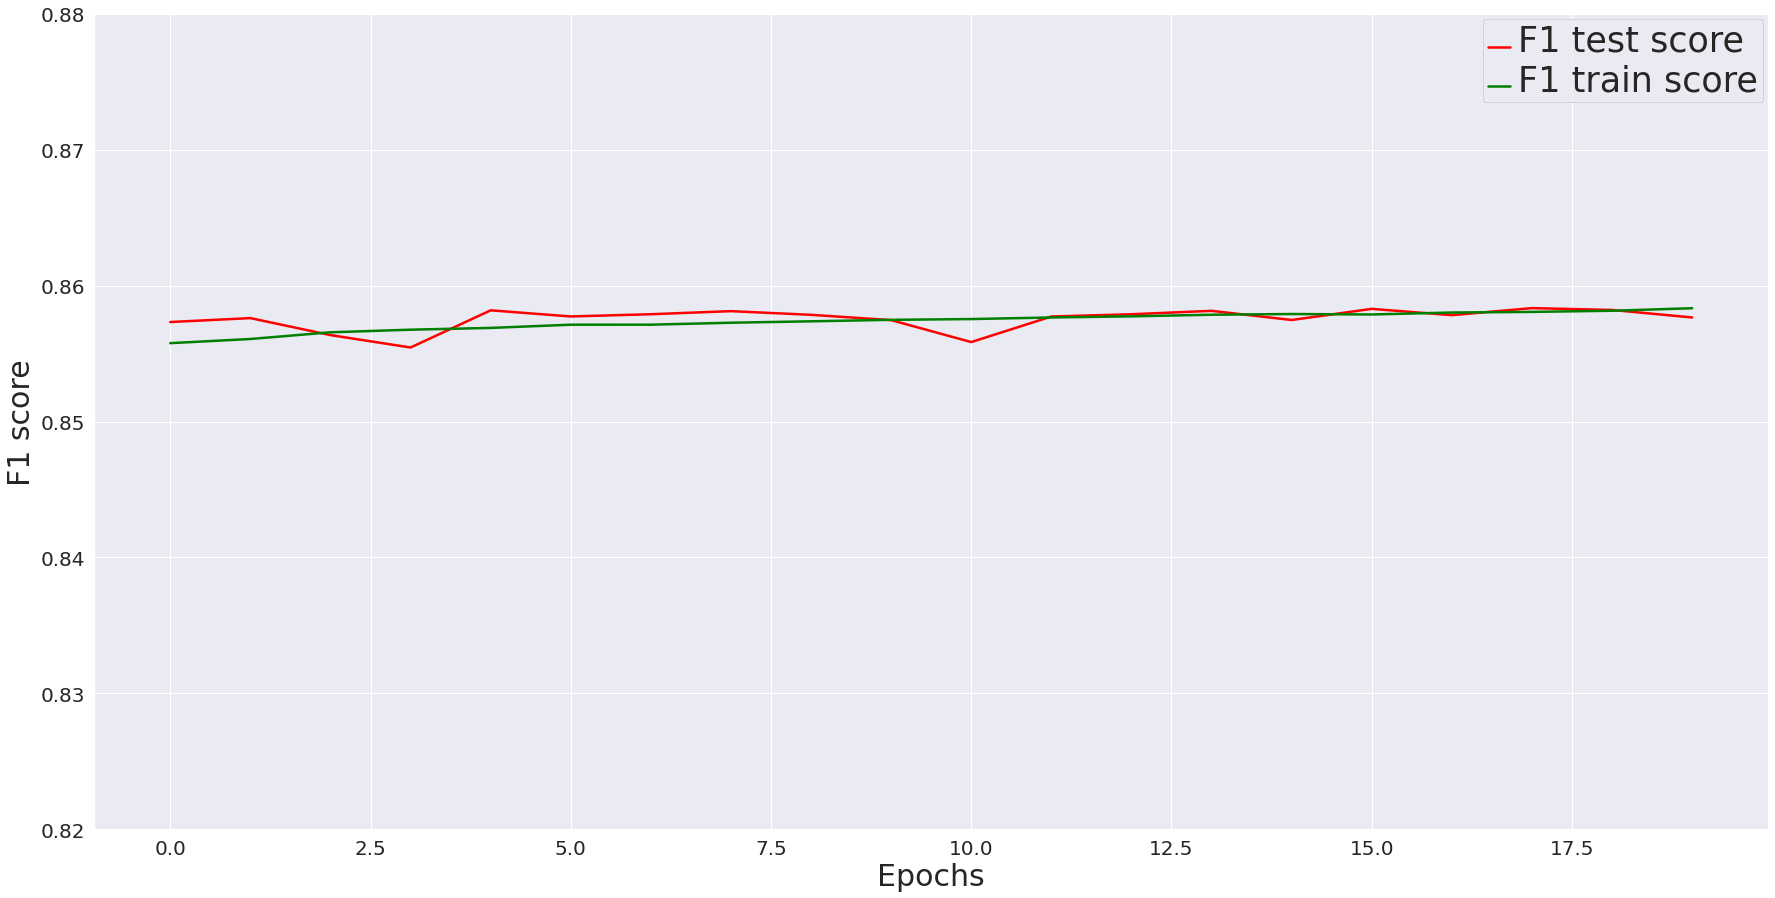

In [43]:
plot_model_scores(F1_train, F1_test, epochs=20,set_ylim=(0.82,0.88))

## 2. CONVOLUTIONAL NN 

In [18]:
class CNN_multitask(nn.Module):
  """Multi-task Convolutional neural network.
      2 shared convolutions and a single convolution followed by a fully connected
      layer for each of the 3 tasks. It uses ReLU activation functions.
      
      Parameters
      --------------
      fc_layer_size (int): size of the fully connected layer
      """

  def __init__(self, fc_layer_size):
    super(CNN_multitask, self).__init__()
    self.fc_layer_size = fc_layer_size 
    
    self.layer1 = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=15, stride=2, padding=1), #The average word length in English language is 4.7 characters.
            nn.BatchNorm1d(32), 
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=10, stride=2))

    self.layer2 = nn.Sequential(
            nn.Conv1d(32, 32, kernel_size=15, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=10, stride=2))
    
    self.single_layer3_1 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=15, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=10, stride=2))
    
    self.single_layer3_2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=15, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=10, stride=2))
    
    self.single_layer3_3 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=15, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=10, stride=2))
        
    self.drop_out1 = nn.Dropout(p=0.3)
    self.drop_out2 = nn.Dropout(p=0.4)
    self.drop_out3 = nn.Dropout(p=0.5)
    
    self.single_last_layer1_1 = nn.Linear(self.fc_layer_size, 1000) 
    self.single_last_layer2_1 = nn.Linear(1000, 5)

    self.single_last_layer1_2 = nn.Linear(self.fc_layer_size, 1000) 
    self.single_last_layer2_2 = nn.Linear(1000, 5)

    self.single_last_layer1_3 = nn.Linear(self.fc_layer_size, 1000) 
    self.single_last_layer2_3 = nn.Linear(1000, 5)


  def forward(self, x):
      
      # 2 shared blocks 
    out = self.layer1(x)
    out = self.drop_out1(out)
    out = self.layer2(out)
    out = self.drop_out2(out)

      # single convolution + fully connected layer for each task
    out1 = self.single_layer3_1(out)
    out1 = self.drop_out3(out1)
    out1 = out1.reshape(out1.size(0), -1) 
    out1 = self.single_last_layer1_1(out1)
    out1 = self.single_last_layer2_1(out1)

    out2 = self.single_layer3_2(out) 
    out2 = self.drop_out2(out2)
    out2 = out2.reshape(out2.size(0), -1) 
    out2 = self.single_last_layer1_2(out2)
    out2 = self.single_last_layer2_2(out2)

    out3 = self.single_layer3_3(out) 
    out3 = self.drop_out3(out3)
    out3 = out3.reshape(out3.size(0), -1) 
    out3 = self.single_last_layer1_3(out3)
    out3 = self.single_last_layer2_3(out3)

 
    return out1, out2, out3

### Hyperparameters Tuning

In [154]:
train_loader, test_loader = build_DataLoader(
        data_processed=data_processed,
        network_type='CNN', 
        usage='hyper_tuning'
    )

In [50]:
model=CNN_multitask(fc_layer_size=7936)

if torch.cuda.device_count() >= 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)

model.to(device)

Let's use 1 GPUs!


DataParallel(
  (module): CNN_multitask(
    (layer1): Sequential(
      (0): Conv1d(1, 32, kernel_size=(15,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=10, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Sequential(
      (0): Conv1d(32, 32, kernel_size=(15,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=10, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (single_layer3_1): Sequential(
      (0): Conv1d(32, 64, kernel_size=(15,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=10, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (single_layer3_2): Sequential(
      (0): Conv1

In [72]:
num_epochs = 2
criterion = nn.CrossEntropyLoss()

In [79]:
param_search = Param_Search(model, train_loader, test_loader,
            criterion, num_epochs, n_trials=5, study_name='hp_CNN')

param_search.run_trial()

[I 2021-06-03 17:40:35,961] Using an existing study with name 'hp_CNN' instead of creating a new one.


Study statistics: 
  Number of finished trials:  11
  Number of pruned trials:  0
  Number of complete trials:  5
Best trial:
  Value:  0.8516766082912863
  Params: 
    lr: 0.006449638488276868
    optimizer: Adam


In [83]:
best_model_CNN_hp = param_search.save_best_model('CNN/best_model_CNN_hp.pt')

### Model Testing

In [155]:
train_loader, test_loader = build_DataLoader(
        data_processed=data_processed,
        network_type='CNN', 
        usage='model_testing'
    )

In [20]:
model=CNN_multitask(fc_layer_size=7936)

if torch.cuda.device_count() >= 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)

model.to(device)

Let's use 1 GPUs!


DataParallel(
  (module): CNN_multitask(
    (layer1): Sequential(
      (0): Conv1d(1, 32, kernel_size=(15,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=10, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Sequential(
      (0): Conv1d(32, 32, kernel_size=(15,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=10, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (single_layer3_1): Sequential(
      (0): Conv1d(32, 64, kernel_size=(15,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=10, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (single_layer3_2): Sequential(
      (0): Conv1

In [21]:
num_epochs = 20
criterion = nn.CrossEntropyLoss()

In [22]:
best_lr = 0.006449638488276868 #train
optimizer = optim.Adam(model.parameters(), lr=best_lr)

In [23]:
F1_train, F1_test = fit(model, train_loader, test_loader, criterion, optimizer, 
                        num_epochs, filename_path='CNN/cnn_testing', patience=3, verbose=True)

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 	Training F1 score: 0.8297 	Test F1 score: 0.8543 	Training Loss: 25368.5470 	Test Loss: 3412.3309
Epoch: 2 	Training F1 score: 0.8526 	Test F1 score: 0.8512 	Training Loss: 20561.3520 	Test Loss: 3414.4406
EarlyStopping counter: 1 out of 3
Epoch: 3 	Training F1 score: 0.8528 	Test F1 score: 0.8543 	Training Loss: 20481.9627 	Test Loss: 3410.7506
Epoch: 4 	Training F1 score: 0.8529 	Test F1 score: 0.8543 	Training Loss: 20482.1883 	Test Loss: 3411.4444
EarlyStopping counter: 1 out of 3
Epoch: 5 	Training F1 score: 0.8527 	Test F1 score: 0.8512 	Training Loss: 20482.3010 	Test Loss: 3411.1503
EarlyStopping counter: 2 out of 3
Epoch: 6 	Training F1 score: 0.8529 	Test F1 score: 0.8543 	Training Loss: 20481.5251 	Test Loss: 3409.1412
Epoch: 7 	Training F1 score: 0.8528 	Test F1 score: 0.8512 	Training Loss: 20484.8027 	Test Loss: 3417.3357
EarlyStopping counter: 1 out of 3
Epoch: 8 	Training F1 score: 0.8528 	Test F1 score: 0.8512 	Training Loss: 20481.5949 	Test Loss: 3422.4139


In [24]:
save_best_model(model, 'CNN/best_model_CNN_test.pt')

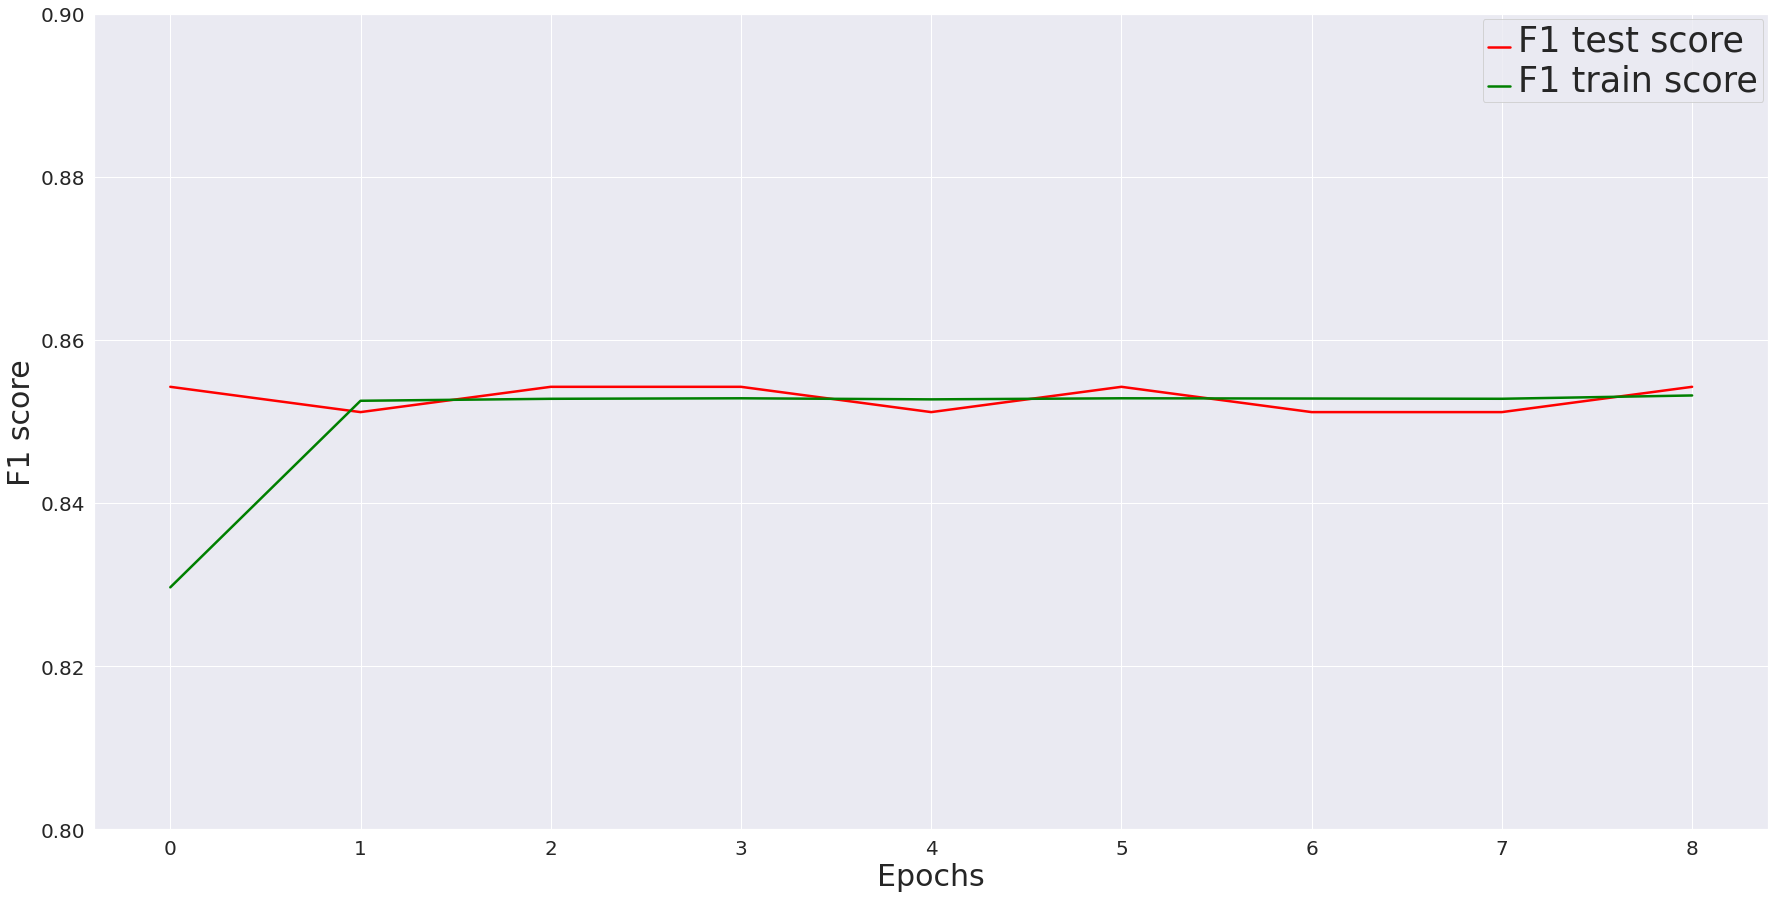

In [26]:
plot_model_scores(F1_train, F1_test, epochs=9, set_ylim=(0.8,0.9))

## 3. DOC2VEC+ CONVOLUTIONAL NN 

In [18]:
import torch.nn as nn

class CNN_2_multitask(nn.Module):
  """Multi-task Convolutional neural network.
      2 shared convolutions and a single convolution followed by a fully connected
      layer for each of the 3 tasks. It uses ReLU activation functions.
      
      Parameters
      --------------
      fc_layer_size (int): size of the fully connected layer
  """
  def __init__(self, fc_layer_size):
    super(CNN_2_multitask, self).__init__()
    self.fc_layer_size = fc_layer_size 
    
    self.layer1 = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, stride=1, padding=1), #The average word length in English language is 4.7 characters.
            nn.BatchNorm1d(32), 
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2))

    self.layer2 = nn.Sequential(
            nn.Conv1d(32, 32, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=10, stride=2))
    
    self.single_layer3_1 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=15, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=10, stride=2))
    
    self.single_layer3_2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=15, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=10, stride=2))
    
    self.single_layer3_3 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=15, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=10, stride=2))
        
    self.drop_out1 = nn.Dropout(p=0.3)
    self.drop_out2 = nn.Dropout(p=0.4)
    self.drop_out3 = nn.Dropout(p=0.5)
    
    self.single_last_layer1_1 = nn.Linear(self.fc_layer_size, 1000) 
    self.single_last_layer2_1 = nn.Linear(1000, 5)

    self.single_last_layer1_2 = nn.Linear(self.fc_layer_size, 1000) 
    self.single_last_layer2_2 = nn.Linear(1000, 5)

    self.single_last_layer1_3 = nn.Linear(self.fc_layer_size, 1000) 
    self.single_last_layer2_3 = nn.Linear(1000, 5)


  def forward(self, x):
      
      # 2 shared blocks
    out = self.layer1(x)
    out = self.drop_out1(out)
    out = self.layer2(out)
    out = self.drop_out2(out)

      # single convolution + fully connected layer for each task
    out1 = self.single_layer3_1(out)
    out1 = self.drop_out3(out1)
    out1 = out1.reshape(out1.size(0), -1) 
    out1 = self.single_last_layer1_1(out1)
    out1 = self.single_last_layer2_1(out1)

    out2 = self.single_layer3_2(out) 
    out2 = self.drop_out2(out2)
    out2 = out2.reshape(out2.size(0), -1) 
    out2 = self.single_last_layer1_2(out2)
    out2 = self.single_last_layer2_2(out2)

    out3 = self.single_layer3_3(out) 
    out3 = self.drop_out3(out3)
    out3 = out3.reshape(out3.size(0), -1) 
    out3 = self.single_last_layer1_3(out3)
    out3 = self.single_last_layer2_3(out3)

 
    return out1, out2, out3

### Hyperparameters Tuning

In [156]:
train_loader, test_loader = build_DataLoader(
        data_processed=data_processed,
        network_type='D2V_CNN', 
        usage='hyper_tuning'
    )

In [20]:
model=CNN_2_multitask(fc_layer_size=64)

if torch.cuda.device_count() >= 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)

model.to(device)

Let's use 1 GPUs!


DataParallel(
  (module): CNN_2_multitask(
    (layer1): Sequential(
      (0): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Sequential(
      (0): Conv1d(32, 32, kernel_size=(5,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=10, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (single_layer3_1): Sequential(
      (0): Conv1d(32, 64, kernel_size=(15,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=10, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (single_layer3_2): Sequential(
      (0): Conv1d

In [21]:
num_epochs = 2
criterion = nn.CrossEntropyLoss()

In [31]:
param_search = Param_Search(model, train_loader, test_loader,
            criterion, num_epochs, n_trials=5, study_name='hp_D2V_CNN')

param_search.run_trial()

[I 2021-06-04 07:26:25,981] Using an existing study with name 'hp_D2V_CNN' instead of creating a new one.


Study statistics: 
  Number of finished trials:  6
  Number of pruned trials:  0
  Number of complete trials:  5
Best trial:
  Value:  0.8541504522166743
  Params: 
    lr: 0.0011082421498591032
    optimizer: RMSprop


In [24]:
best_model_D2V_CNN_hp = param_search.save_best_model('D2V_CNN/best_model_D2V_CNN_hp.pt')

### Model Testing

In [157]:
train_loader, test_loader = build_DataLoader(
        data_processed=data_processed,
        network_type='D2V_CNN', 
        usage='model_testing'
    )

In [69]:
model=CNN_2_multitask(fc_layer_size=64)

if torch.cuda.device_count() >= 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)

model.to(device)

Let's use 1 GPUs!


DataParallel(
  (module): CNN_2_multitask(
    (layer1): Sequential(
      (0): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Sequential(
      (0): Conv1d(32, 32, kernel_size=(5,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=10, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (single_layer3_1): Sequential(
      (0): Conv1d(32, 64, kernel_size=(15,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=10, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (single_layer3_2): Sequential(
      (0): Conv1d

In [70]:
num_epochs = 20
criterion = nn.CrossEntropyLoss()

In [71]:
best_lr = 0.0011082421498591032
optimizer = optim.RMSprop(model.parameters(), lr=best_lr)

In [31]:
F1_train, F1_test = fit(model, train_loader, test_loader, criterion, optimizer, 
                        num_epochs, filename_path='D2V_CNN/d2v_cnn_testing', patience=3, verbose=True)

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 	Training F1 score: 0.8221 	Test F1 score: 0.8544 	Training Loss: 20703.4214 	Test Loss: 3407.6025
Epoch: 2 	Training F1 score: 0.8510 	Test F1 score: 0.8544 	Training Loss: 20460.7359 	Test Loss: 3408.3935
EarlyStopping counter: 1 out of 3
Epoch: 3 	Training F1 score: 0.8525 	Test F1 score: 0.8544 	Training Loss: 20455.6980 	Test Loss: 3408.0285
EarlyStopping counter: 2 out of 3
Epoch: 4 	Training F1 score: 0.8531 	Test F1 score: 0.8544 	Training Loss: 20455.1068 	Test Loss: 3405.5855
Epoch: 5 	Training F1 score: 0.8533 	Test F1 score: 0.8544 	Training Loss: 20454.5309 	Test Loss: 3406.7605
EarlyStopping counter: 1 out of 3
Epoch: 6 	Training F1 score: 0.8532 	Test F1 score: 0.8541 	Training Loss: 20460.4296 	Test Loss: 3409.4262
EarlyStopping counter: 2 out of 3
Epoch: 7 	Training F1 score: 0.8533 	Test F1 score: 0.8518 	Training Loss: 20455.2152 	Test Loss: 3405.7008
EarlyStopping counter: 3 out of 3
Early stopping the training


In [27]:
save_best_model(model, 'D2V_CNN/best_model_D2V_CNN_test.pt')

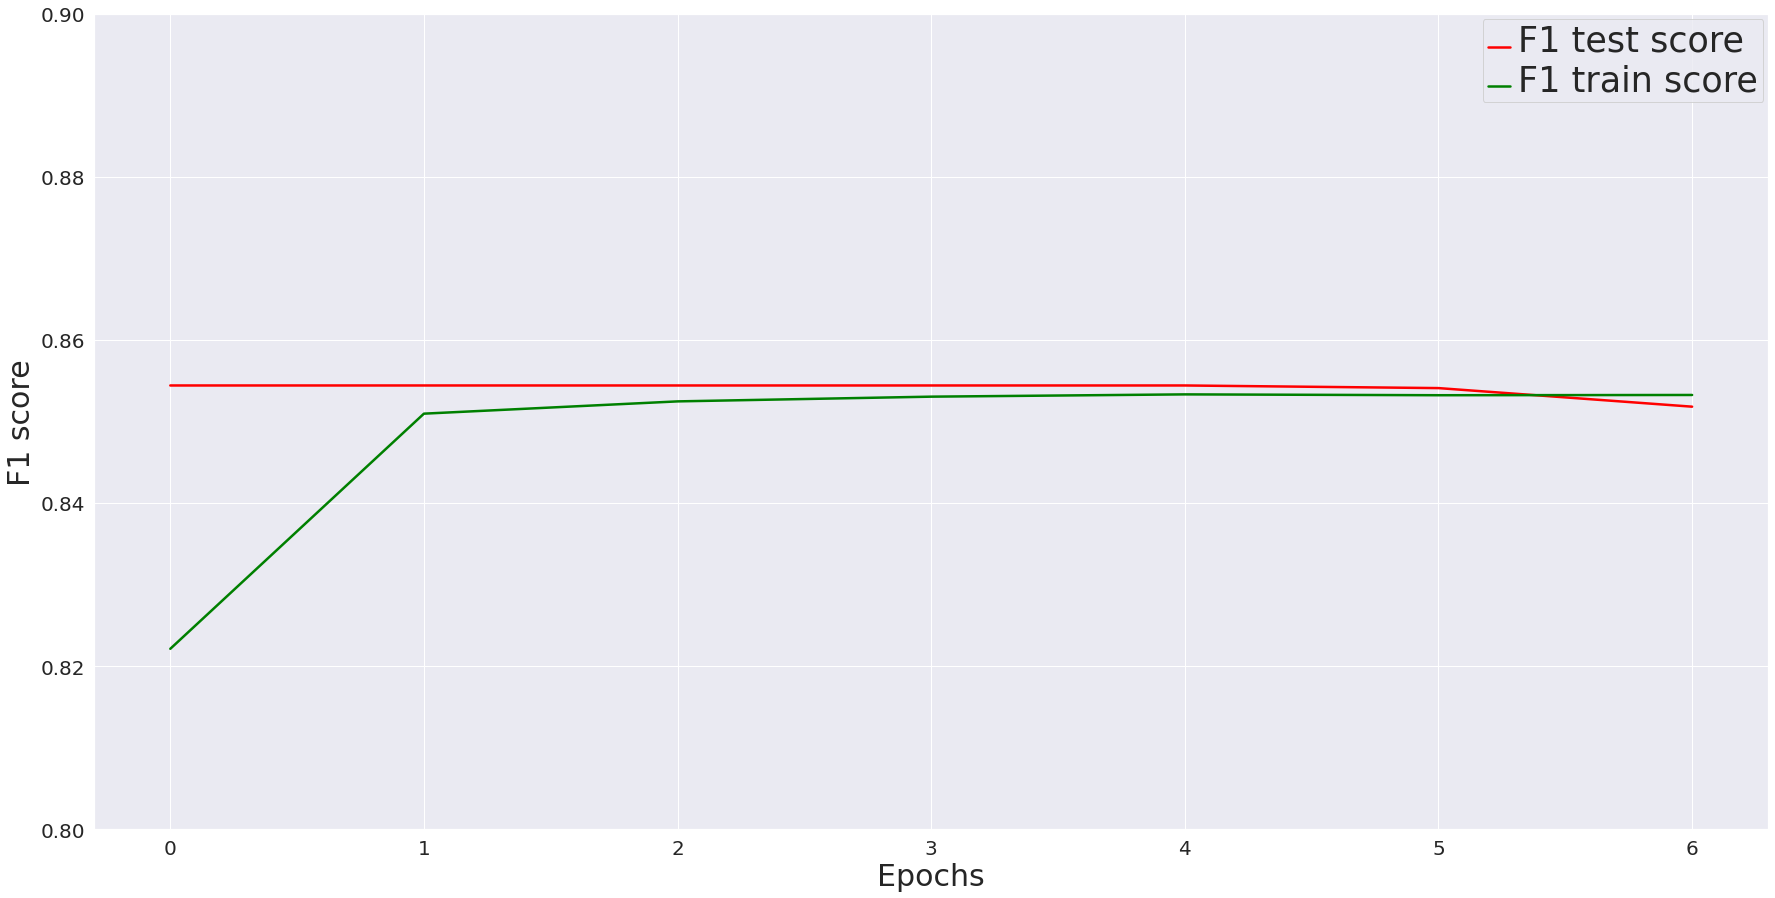

In [34]:
plot_model_scores(F1_train, F1_test, epochs=7, set_ylim=(0.8,0.9))

In [ ]:
F1_train, F1_test = fit(model, train_loader_dict['D2V_CNN'], test_loader_dict['D2V_CNN'], criterion, optimizer, 
                        num_epochs, filename_path='D2V_CNN/d2v_cnn_testing', patience=3, verbose=True)

## 4. MULTIMODAL NN

In [18]:
import optuna
import torch.nn as nn
#import thop
import torch.optim as optim
import pickle
import re

class Param_Search_Multimodal():

  """Performs the hyper parameters tuning by using a TPE (Tree-structured Parzen Estimator) 
    algorithm sampler.  
    
    Parameters:
    ------------------
    model (torch.nn.Module): neural network model.
    train_loader (DataLoader): dictionary of training DataLoader objects. Keys of the
        dictionary must be 'FFNN', 'CNN', 'D2V_CNN'.
    test_loader (DataLoader): dictionary of testing DataLoader objects. Keys of the
        dictionary must be 'FFNN', 'CNN', 'D2V_CNN'.
    criterion : loss function for training the model.
    num_epochs (int): number of epochs.
    study_name (str): name of the Optuna study object.
    n_trial (int): number of trials to perform in the Optuna study.
        Default: 4
    
    Attributes:
    ------------------
    best_model: stores the weights of the common layers of the best performing model.
    
    Returns:
    ------------------
  Prints values of the optimised hyperparameters and saves the parameters of the best model.
    """
    
  def __init__(self, 
               model, 
               train_loader, 
               test_loader,
               criterion,
               num_epochs,
               n_trials,
               study_name):
    self.model = model
    self.train_loader = train_loader
    self.test_loader = test_loader
    self.criterion = criterion
    self.num_epochs = num_epochs
    self.n_trials = n_trials
    self.study_name = study_name
    self.len_train_loader = len(train_loader['FFNN'])
    self.len_test_loader = len(test_loader['FFNN'])
    self.best_model = None

  def objective(self, trial):
    """Defines the objective to be optimised (F1 test score) and saves
    each final model.
    """
    
    # generate the model
    model = self.model

    # generate the possible optimizers
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop"])
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    
    # convert model data type to double
    model = model.double()
    
    # Define the training and testing phases
    for epoch in tqdm(range(1, num_epochs + 1)):
      train_loss = 0.0
      test_loss = 0.0
      f1_test = 0.0
    
      # set the model in training modality
      model.train()
      for load1, load2, load3 in tqdm(zip(self.train_loader['FFNN'],
                                          self.train_loader['CNN'],
                                          self.train_loader['D2V_CNN']), 
                                      desc='Training model', total = self.len_train_loader):
        x_1, target1, target2, target3 = load1
        x_2, _, _, _ = load2
        x_3, _, _, _ = load3

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output1, output2, output3 = model([x_1.double(), x_2.double(), x_3.double()])
        # calculate the batch loss as a sum of the single losses
        loss = self.criterion(output1, target1) + self.criterion(output2, target2) + self.criterion(output3, target3)
        # backward pass: compute gradient of the loss wrt model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()      
        
        
      # set the model in testing modality
      model.eval()
      for load1, load2, load3 in tqdm(zip(self.test_loader['FFNN'],
                                          self.test_loader['CNN'],
                                          self.test_loader['D2V_CNN']), 
                                      desc='Testing model', total = self.len_test_loader):
        x_1, target1, target2, target3 = load1
        x_2, _,_,_ = load2
        x_3, _,_,_ = load3

        # forward pass: compute predicted outputs by passing inputs to the model
        output1, output2, output3 = model([x_1.double(), x_2.double(), x_3.double()])
        # calculate the batch loss as a sum of the single losses
        loss = self.criterion(output1, target1) + self.criterion(output2, target2) + self.criterion(output3, target3)
        # update test loss 
        test_loss += loss.item() 
        # calculate F1 test score as weighted sum of the single F1 scores
        f1_test += ( F1(output1,target1) + F1(output2,target2) + F1(output3,target3) )/3
        
      # calculate epoch score by dividing by the number of observations
      f1_test /= self.len_test_loader
      # pass the score of the epoch to the study to monitor the intermediate objective values    
      trial.report(f1_test, epoch)

    # save the final model named with the number of the trial 
    with open("{}{}.pickle".format(self.study_name,trial.number), "wb") as fout:
      pickle.dump(model, fout)
    
    # return F1 score to the study        
    return f1_test



  def run_trial(self):
    """Runs Optuna study and stores the best model in class attribute 'best_model'."""

    # create a new study or load a pre-existing study. use sqlite backend to store the study.
    study = optuna.create_study(study_name=self.study_name, direction="maximize", 
                                storage='sqlite:///SA_optuna_tuning.db', load_if_exists=True)

    complete_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE]
    pruned_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED]
    
    # if the number of already completed trials is lower than the total number of trials passed as
    #argument, perform the remaining trials 
    if len(complete_trials)<self.n_trials:
        # set the number of trials to be performed equal to the number of missing trials
        self.n_trials -= len(complete_trials)
        study.optimize(self.objective, n_trials=self.n_trials)
        pruned_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED]
        complete_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE]
        
    # store the best model found in the class
    with open("{}{}.pickle".format(self.study_name, study.best_trial.number), "rb") as fin:
        best_model = pickle.load(fin)

    self.best_model = best_model
    
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
      print("    {}: {}".format(key, value))
                                          

    with open("{}{}.pickle".format(self.study_name, study.best_trial.number), "rb") as fin:
      best_model = pickle.load(fin)
    
    # store only best model
    self.best_model = best_model

In [19]:
from tqdm.auto import tqdm

def fit_multimodal(model, 
                   train_loader, 
                   test_loader, 
                   criterion, 
                   optimizer, 
                   num_epochs, 
                   filename_path,
                   patience=3, 
                   delta=0,
                   verbose=True): 
  """Performs the training of the multitask model. It implements also early stopping
    
    Parameters:
    ------------------
    model (torch.nn.Module): neural network model.
    train_loader (DataLoader): dictioary of training DataLoader objects. Keys of the
        dictionary must be 'FFNN', 'CNN', 'D2V_CNN'.
    test_loader (DataLoader): dictionary of testing DataLoader objects. Keys of the
        dictionary must be 'FFNN', 'CNN', 'D2V_CNN'.
    criterion: loss function for training the model.
    optimizer (torch.optim): optimization algorithm for training the model. 
    num_epochs (int): number of epochs.
    filename_path (str): where the weights of the model at each epoch will be stored. 
        Indicate only the name of the folder.
    patience (int): number of epochs in which the test error is not anymore decreasing
        before stopping the training.
    delta (int): minimum decrease in the test error to continue with the training.
        Default:0
    verbose (bool): prints the training error, test error, F1 training score, F1 test score 
        at each epoch.
        Default: True
    
    Attributes:
    ------------------
    f1_train_scores: stores the F1 training scores for each epoch.
    f1_test_scores: stores the F1 test scores for each epoch.
    
    Returns:
    ------------------
    Lists of F1 training scores and F1 test scores at each epoch.
    Prints training error, test error, F1 training score, F1 test score at each epoch.
    """

  basepath = 'exp'

  # keep track of epoch losses 
  f1_train_scores = []
  f1_test_scores = []

  # convert model data type to double
  model = model.double()

  # define early stopping
  early_stopping = EarlyStopping(patience=patience, delta=delta, verbose=True)

  len_train_loader = len(train_loader['FFNN'])
  len_test_loader = len(test_loader['FFNN'])
    

  for epoch in tqdm(range(1, num_epochs + 1), desc='Epochs'):
    train_loss = 0.0
    test_loss = 0.0
    
    f1_train = 0.0
    f1_test = 0.0
    
    # if there is already a trained model stored for a specific epoch, load the model
    #and don't retrain the model
    PATH = os.path.join(basepath, filename_path + '_' + str(epoch) + '.pt')
    if os.path.exists(PATH):
      checkpoint = torch.load(PATH)
      model.load_state_dict(checkpoint['model_state_dict'])
      f1_train = checkpoint['F1_train']
      f1_test = checkpoint['F1_test']
      train_loss = checkpoint['train_loss']
      test_loss = checkpoint['test_loss']
        
    else:
      # set the model in training modality
      model.train()
      for load1, load2, load3 in tqdm(zip(train_loader['FFNN'],
                                          train_loader['CNN'],
                                          train_loader['D2V_CNN']), 
                                      desc='Training model', total = len_train_loader):
        x_1, target1, target2, target3 = load1
        x_2, _,_,_ = load2
        x_3, _,_,_ = load3
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output1, output2, output3 = model([x_1.double(), x_2.double(), x_3.double()])
        # calculate the batch loss as the sum of all the losses
        loss = criterion(output1, target1) + criterion(output2, target2) + criterion(output3, target3)
        # backward pass: compute gradient of the loss wrt model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()
        # calculate F1 training score as a weighted sum of the single F1 scores
        f1_train += ( F1(output1,target1) + F1(output2,target2) + F1(output3,target3) )/3
        
        
      # set the model in testing modality
      model.eval()
      for load1, load2, load3 in tqdm(zip(test_loader['FFNN'],
                                          test_loader['CNN'],
                                          test_loader['D2V_CNN']), 
                                      desc='Testing model', total = len_test_loader):
        x_1, target1, target2, target3 = load1
        x_2, _,_,_ = load2
        x_3, _,_,_ = load3
        # forward pass: compute predicted outputs by passing inputs to the model
        output1, output2, output3 = model([x_1.double(), x_2.double(), x_3.double()])
        # calculate the batch loss as the sum of all the losses
        loss = criterion(output1, target1) + criterion(output2, target2) + criterion(output3, target3)
        # update test loss
        test_loss += loss.item()
        # calculate F1 test score as a weighted sum of the single F1 scores
        f1_test += ( F1(output1,target1) + F1(output2,target2) + F1(output3,target3) ) /3
        
        
    # save the model weights, epoch, scores and losses at each epoch
    model_param = model.state_dict()
    PATH = os.path.join(basepath, filename_path + '_' + str(epoch) + '.pt')
    torch.save({'epoch': epoch,
                'model_state_dict': model_param,
                'F1_train': f1_train,
                'F1_test': f1_test,
                'train_loss': train_loss,
                'test_loss': test_loss},
               PATH)
     
    
    # calculate epoch score by dividing by the number of observations
    f1_train /= len_train_loader
    f1_test /= len_test_loader
    # store epoch scores
    f1_train_scores.append(f1_train)    
    f1_test_scores.append(f1_test)
      
    # print training/test statistics 
    if verbose == True:
      print('Epoch: {} \tTraining F1 score: {:.4f} \tTest F1 score: {:.4f} \tTraining Loss: {:.4f} \tTest Loss: {:.4f}'.format(
      epoch, f1_train, f1_test, train_loss, test_loss))
      
    # early stop the model if the test loss is not improving
    early_stopping(test_loss, model)
    if early_stopping.early_stop:
      print('Early stopping the training')
      # reload the previous best model before the test loss started decreasing
      best_checkpoint = torch.load(os.path.join(basepath,filename_path + '_' + '{}'.format(epoch-patience) + '.pt'))
      model.load_state_dict(best_checkpoint['model_state_dict'])
      break
    
        
  # return the scores at each epoch
  return f1_train_scores, f1_test_scores

In [20]:
import torch.nn as nn

class FFNN_multitask_pre(nn.Module):
  def __init__(self):
    super(FFNN_multitask_pre, self).__init__()
    
    self.layer1 = nn.Sequential(
        nn.Linear(261, 4000), 
        nn.ReLU(),
        nn.Linear(4000, 2000),
        nn.ReLU()) 

    self.drop_out1 = nn.Dropout(p=0.3)

  def forward(self, x):
      
      # first block in common
    out = self.layer1(x)
    out = self.drop_out1(out)
    out = out.reshape(out.size(0), -1) 
 
    return out

In [21]:
import torch.nn as nn

class CNN_multitask_pre(nn.Module):
  def __init__(self):
    super(CNN_multitask_pre, self).__init__()
    
    self.layer1 = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=15, stride=2, padding=1), #The average word length in English language is 4.7 characters.
            nn.BatchNorm1d(32), 
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=10, stride=2))

    self.layer2 = nn.Sequential(
            nn.Conv1d(32, 32, kernel_size=15, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=10, stride=2))
        
    self.drop_out1 = nn.Dropout(p=0.3)
    self.drop_out2 = nn.Dropout(p=0.4)


  def forward(self, x):
      
      # first blocks in common
    out = self.layer1(x)
    out = self.drop_out1(out)
    out = self.layer2(out)
    out = self.drop_out2(out)
    out = out.reshape(out.size(0), -1) 
 
    return out

In [22]:
import torch.nn as nn

class CNN_2_multitask_pre(nn.Module):
  def __init__(self):
    super(CNN_2_multitask_pre, self).__init__()
    
    self.layer1 = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, stride=1, padding=1), #The average word length in English language is 4.7 characters.
            nn.BatchNorm1d(32), 
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2))

    self.layer2 = nn.Sequential(
            nn.Conv1d(32, 32, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2))
        
    self.drop_out1 = nn.Dropout(p=0.3)
    self.drop_out2 = nn.Dropout(p=0.4)


  def forward(self, x):
      
      # first blocks in common
    out = self.layer1(x)
    out = self.drop_out1(out)
    out = self.layer2(out)
    out = self.drop_out2(out)
    out = out.reshape(out.size(0), -1) 
 
    return out

In [23]:
import torch.nn as nn
import torch.optim as optim


class MultimodalMultitask_NN(nn.Module):
  def __init__(self, concat_layer_size, hyperparameters_tuning=False):
    super(MultimodalMultitask_NN, self).__init__()
    #Like in other object-oriented languages, it allows you to call 
    #methods of the superclass in your subclass. The primary use case of 
    #this is to extend the functionality of the inherited method.
    
    # input parameters
    self.hyperparameters_tuning = hyperparameters_tuning
    self.concat_layer_size = concat_layer_size
    
    # VGG convolutional neural network
    self.FFNN_multitask = FFNN_multitask_pre()
    self.FFNN_multitask = nn.DataParallel(self.FFNN_multitask)
    self.FFNN_multitask.to(device)

    self.CNN_multitask = CNN_multitask_pre()
    self.CNN_multitask = nn.DataParallel(self.CNN_multitask)
    self.CNN_multitask.to(device)

    self.D2V_CNN_multitask = CNN_2_multitask_pre()
    self.D2V_CNN_multitask = nn.DataParallel(self.D2V_CNN_multitask)
    self.D2V_CNN_multitask.to(device)

    # load previously trained models to find optimal hyperparameters
    if self.hyperparameters_tuning:
      load_model(self.FFNN_multitask, 'FFNN/best_model_FFNN_hp.pt')
      load_model(self.CNN_multitask, 'CNN/best_model_CNN_hp.pt')
      load_model(self.D2V_CNN_multitask, 'D2V_CNN/best_model_D2V_CNN_hp.pt')
    
    # load previously trained models for final testing
    else:
      load_model(self.FFNN_multitask, 'FFNN/best_model_FFNN_test.pt')
      load_model(self.CNN_multitask, 'CNN/best_model_CNN_test.pt')
      load_model(self.D2V_CNN_multitask, 'D2V_CNN/best_model_D2V_CNN_test.pt')

    # freeze layers
    for param in self.FFNN_multitask.parameters():
      param.requires_grad = False
    for param in self.CNN_multitask.parameters():
      param.requires_grad = False
    for param in self.D2V_CNN_multitask.parameters():
      param.requires_grad = False
      

    # post concat layers

    self.post_layer1 = nn.Sequential(
        nn.Linear(self.concat_layer_size, 4000), # 21072
        nn.ReLU()) 

    self.single_post_layer2_1 = nn.Sequential(
    nn.Linear(4000, 1000),
    nn.ReLU())

    self.single_post_layer2_2 = nn.Sequential(
    nn.Linear(4000, 1000),
    nn.ReLU())

    self.single_post_layer2_3 = nn.Sequential(
    nn.Linear(4000, 1000),
    nn.ReLU())

    self.single_post_last_layer1 = nn.Linear(1000, 2) 
    self.single_post_last_layer2 = nn.Linear(1000, 2)
    self.single_post_last_layer3 = nn.Linear(1000, 2)  

    self.drop_out1 = nn.Dropout(p=0.3)
    self.drop_out2 = nn.Dropout(p=0.4) 

  
  def forward(self, x):

    x_1, x_2, x_3 = x

    out_1 = self.FFNN_multitask(x_1)
    out_2 = self.CNN_multitask(x_2)
    out_3 = self.D2V_CNN_multitask(x_3)

    # concat layer
    out = torch.cat((out_1, out_2, out_3), dim=1)

    # final layer in common
    out = self.post_layer1(out)
    out = self.drop_out1(out)

    # final single layers
    out1 = self.single_post_layer2_1(out)
    out1 = self.drop_out2(out1)
    out1 = self.single_post_last_layer1(out1)

    out2 = self.single_post_layer2_2(out)
    out2 = self.drop_out2(out2)
    out2 = self.single_post_last_layer2(out2)

    out3 = self.single_post_layer2_3(out)
    out3 = self.drop_out2(out3)
    out3 = self.single_post_last_layer3(out3)

    # output softmax
    return out1, out2, out3
    
   # return nn.functional.log_softmax(output, dim=-1) #not needed since it's already applied
   #by cross-entropy loss

### Hyperparameters tuning

In [25]:
train_loader_1, test_loader_1 = build_DataLoader(
        data_processed=data_processed,
        network_type='FFNN', 
        usage='hyper_tuning'
    )

train_loader_2, test_loader_2 = build_DataLoader(
        data_processed=data_processed,
        network_type='CNN', 
        usage='hyper_tuning'
    )

train_loader_3, test_loader_3 = build_DataLoader(
        data_processed=data_processed,
        network_type='D2V_CNN', 
        usage='hyper_tuning'
    )

train_loader_dict = {}
train_loader_dict['FFNN'] = train_loader_1
train_loader_dict['CNN'] = train_loader_2
train_loader_dict['D2V_CNN'] = train_loader_3

test_loader_dict = {}
test_loader_dict['FFNN'] = train_loader_1
test_loader_dict['CNN'] = train_loader_2
test_loader_dict['D2V_CNN'] = train_loader_3

In [26]:
model=MultimodalMultitask_NN(concat_layer_size = 21072,
                             hyperparameters_tuning=True)

if torch.cuda.device_count() >= 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)

model.to(device)

Let's use 1 GPUs!


DataParallel(
  (module): MultimodalMultitask_NN(
    (FFNN_multitask): DataParallel(
      (module): FFNN_multitask_pre(
        (layer1): Sequential(
          (0): Linear(in_features=261, out_features=4000, bias=True)
          (1): ReLU()
          (2): Linear(in_features=4000, out_features=2000, bias=True)
          (3): ReLU()
        )
        (drop_out1): Dropout(p=0.3, inplace=False)
      )
    )
    (CNN_multitask): DataParallel(
      (module): CNN_multitask_pre(
        (layer1): Sequential(
          (0): Conv1d(1, 32, kernel_size=(15,), stride=(2,), padding=(1,))
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool1d(kernel_size=10, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (layer2): Sequential(
          (0): Conv1d(32, 32, kernel_size=(15,), stride=(2,), padding=(1,))
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [27]:
num_epochs = 2
criterion = nn.CrossEntropyLoss()

In [34]:
param_search = Param_Search_Multimodal(
    model, 
    train_loader_dict, 
    test_loader_dict,
    criterion, 
    num_epochs, 
    n_trials=5,
    study_name='hp_MM',
    )

param_search.run_trial()

[I 2021-06-08 07:23:06,287] Using an existing study with name 'hp_MM' instead of creating a new one.


Study statistics: 
  Number of finished trials:  6
  Number of pruned trials:  0
  Number of complete trials:  5
Best trial:
  Value:  0.8537921798877962
  Params: 
    lr: 0.0031872049332274466
    optimizer: RMSprop


### Model Testing

In [24]:
train_loader_1, test_loader_1 = build_DataLoader(
        data_processed=data_processed,
        network_type='FFNN', 
        usage='model_testing'
    )

train_loader_2, test_loader_2 = build_DataLoader(
        data_processed=data_processed,
        network_type='CNN', 
        usage='model_testing'
    )

train_loader_3, test_loader_3 = build_DataLoader(
        data_processed=data_processed,
        network_type='D2V_CNN', 
        usage='model_testing'
    )

train_loader_dict = {}
train_loader_dict['FFNN'] = train_loader_1
train_loader_dict['CNN'] = train_loader_2
train_loader_dict['D2V_CNN'] = train_loader_3

test_loader_dict = {}
test_loader_dict['FFNN'] = train_loader_1
test_loader_dict['CNN'] = train_loader_2
test_loader_dict['D2V_CNN'] = train_loader_3

In [34]:
model=MultimodalMultitask_NN(concat_layer_size = 21072,
                             hyperparameters_tuning=True)

if torch.cuda.device_count() >= 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)

model.to(device)

Let's use 1 GPUs!


DataParallel(
  (module): MultimodalMultitask_NN(
    (FFNN_multitask): DataParallel(
      (module): FFNN_multitask_pre(
        (layer1): Sequential(
          (0): Linear(in_features=261, out_features=4000, bias=True)
          (1): ReLU()
          (2): Linear(in_features=4000, out_features=2000, bias=True)
          (3): ReLU()
        )
        (drop_out1): Dropout(p=0.3, inplace=False)
      )
    )
    (CNN_multitask): DataParallel(
      (module): CNN_multitask_pre(
        (layer1): Sequential(
          (0): Conv1d(1, 32, kernel_size=(15,), stride=(2,), padding=(1,))
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool1d(kernel_size=10, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (layer2): Sequential(
          (0): Conv1d(32, 32, kernel_size=(15,), stride=(2,), padding=(1,))
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [35]:
num_epochs = 20
criterion = nn.CrossEntropyLoss()

In [36]:
best_lr =0.0031872049332274466
optimizer = optim.RMSprop(model.parameters(), lr=best_lr)

In [37]:
F1_train, F1_test = fit_multimodal(model, 
                         train_loader_dict,
                         test_loader_dict,
                         criterion, optimizer, num_epochs,
                         filename_path='MultiNN/mm_testing',
                         verbose=True)

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 	Training F1 score: 0.8479 	Test F1 score: 0.8539 	Training Loss: 154420.0689 	Test Loss: 20471.4133
Epoch: 2 	Training F1 score: 0.8526 	Test F1 score: 0.8539 	Training Loss: 23767.9754 	Test Loss: 20786.5896
EarlyStopping counter: 1 out of 3
Epoch: 3 	Training F1 score: 0.8529 	Test F1 score: 0.8510 	Training Loss: 22855.5745 	Test Loss: 20882.2434
EarlyStopping counter: 2 out of 3
Epoch: 4 	Training F1 score: 0.8529 	Test F1 score: 0.8539 	Training Loss: 22163.8517 	Test Loss: 20468.9483
Epoch: 5 	Training F1 score: 0.8531 	Test F1 score: 0.8539 	Training Loss: 21600.4538 	Test Loss: 20463.9501
Epoch: 6 	Training F1 score: 0.8531 	Test F1 score: 0.8510 	Training Loss: 21422.2577 	Test Loss: 20458.9879
Epoch: 7 	Training F1 score: 0.8531 	Test F1 score: 0.8539 	Training Loss: 21405.4181 	Test Loss: 20509.9908
EarlyStopping counter: 1 out of 3
Epoch: 8 	Training F1 score: 0.8533 	Test F1 score: 0.8535 	Training Loss: 21206.2250 	Test Loss: 20811.6334
EarlyStopping counter: 2 

In [38]:
model_param = model.state_dict()
basepath = 'models'
PATH = os.path.join(basepath, 'MultiNN/best_model_MM_test.pt')
    
torch.save(model_param, PATH)

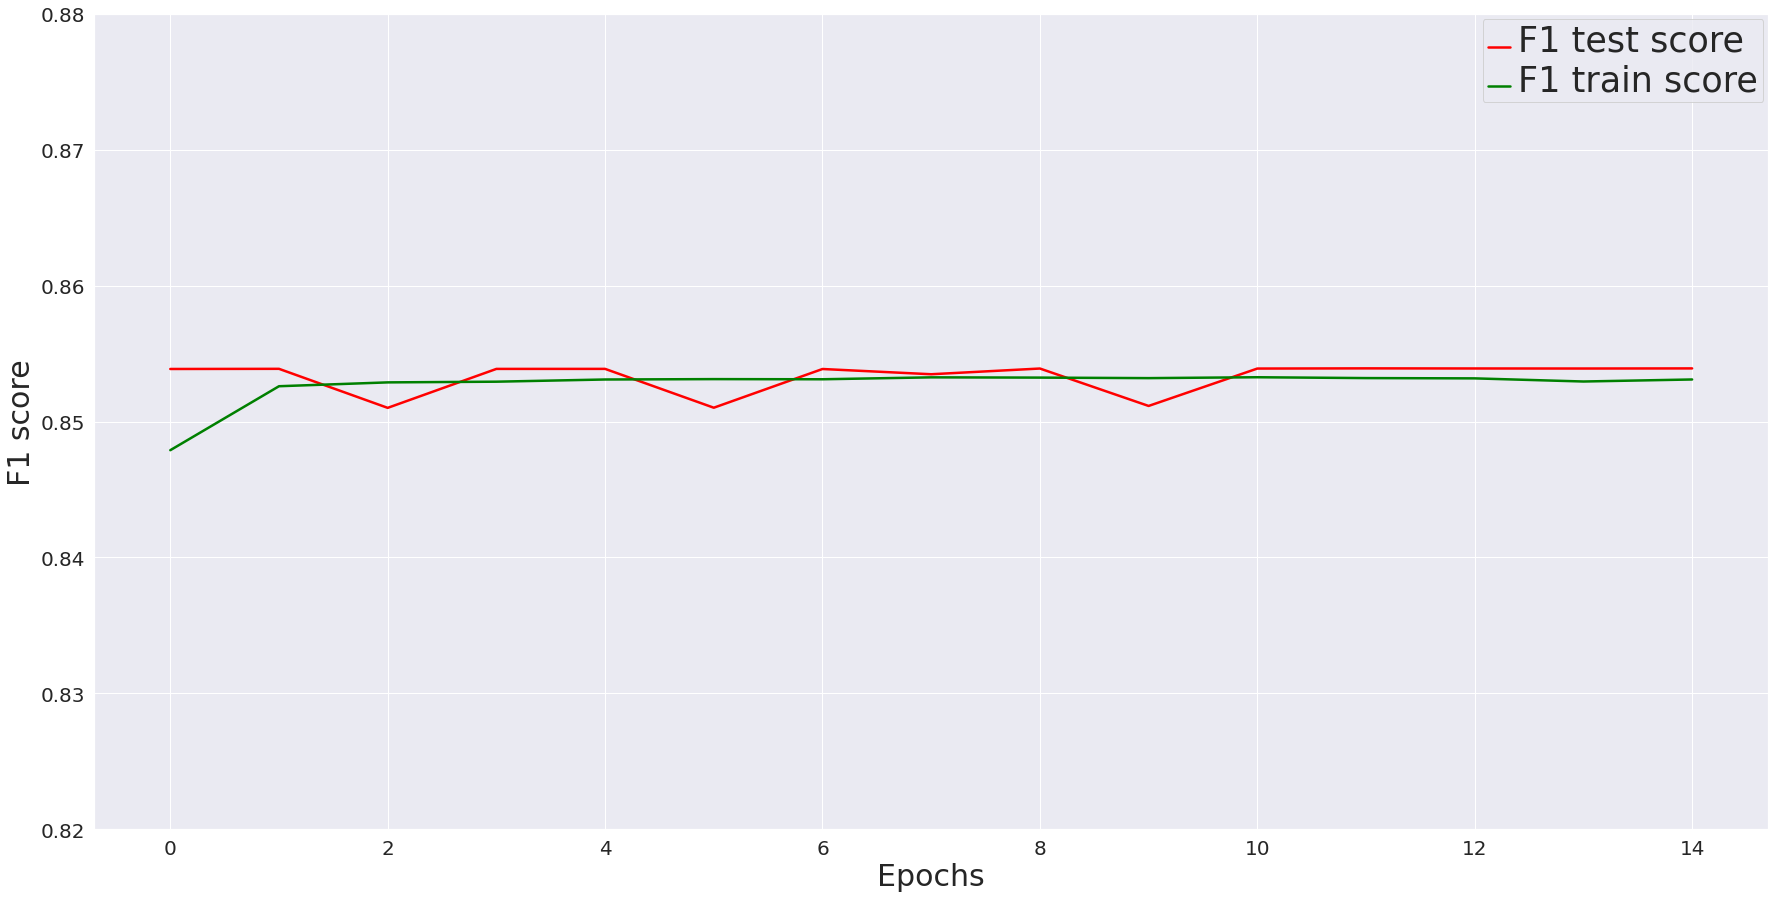

In [44]:
plot_model_scores(F1_train, F1_test, epochs=15, set_ylim=[0.82,0.88])